In [1]:
import pickle
from time import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import uniform
from sklearn.base import clone
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss

from helper_functions import various_metrics_binary_classification

In [2]:
df = pd.read_csv("input/bioresponse/train.csv")
df.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


In [3]:
target_name = "Activity"
y = df.loc[:, target_name]
X = df.drop(target_name, axis="columns")

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=1,
                                                    )

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3000, 1776), (751, 1776), (3000,), (751,))

In [5]:
max_n_trees = 500
to_try_n_trees = np.arange(1, max_n_trees + 1)
metrics = [roc_auc_score, log_loss]

In [6]:
df_results = []
for n_trees in to_try_n_trees:
    rf = RandomForestClassifier(n_estimators=n_trees, random_state=1)
    
    start_time = time()
    
    rf.fit(X_train, y_train)
    
    end_time = time()
    tot_time = end_time - start_time
    
    tmp = {"time": tot_time, "n_trees": n_trees}
    tmp.update(various_metrics_binary_classification(rf, metrics, X_train, y_train, identifier="train"))
    tmp.update(various_metrics_binary_classification(rf, metrics, X_test, y_test, identifier="test"))
    
    df_results.append(tmp)

df_results = pd.DataFrame(df_results)
df_results.head()

,time,n_trees,roc_auc_score_train,log_loss_train,roc_auc_score_test,log_loss_test
0,0.059565,1,0.880931,4.098647,0.650216,11.957643
1,0.041914,2,0.959256,0.746511,0.711234,5.900560
2,0.054340,3,0.981766,0.275128,0.739115,3.452125
3,0.066847,4,0.991497,0.157704,0.765446,2.565341
4,0.079281,5,0.995888,0.140903,0.787894,1.815284


In [9]:
df_results.tail()

,time,n_trees,roc_auc_score_train,log_loss_train,roc_auc_score_test,log_loss_test
495,6.344218,496,1.0,0.128402,0.868161,0.464764
496,6.940487,497,1.0,0.128400,0.868090,0.464756
497,6.971453,498,1.0,0.128395,0.868154,0.464728
498,6.517131,499,1.0,0.128380,0.868215,0.464673
499,6.886906,500,1.0,0.128403,0.868240,0.464639


How do metrics change with the number of trees?

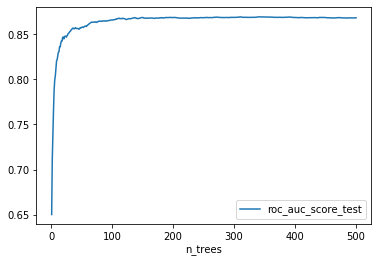

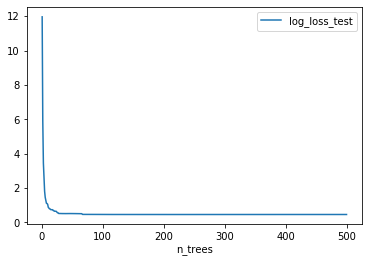

In [11]:
df_results.plot(x="n_trees", y="roc_auc_score_test")
df_results.plot(x="n_trees", y="log_loss_test");

Clearly, both metrics get better while `n_trees` increases. This is especially evident when `n_trees` is very small.
Create clearer graphs that show the plateaus:

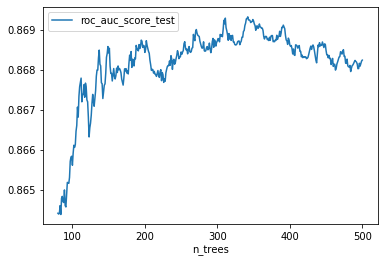

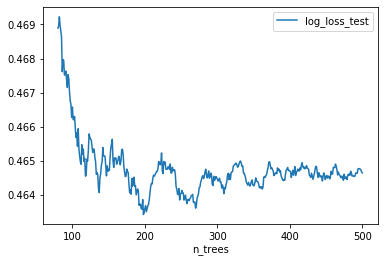

In [13]:
min_trees_to_consider = 80
df_good = df_results.query(f"n_trees >= {min_trees_to_consider}")

df_good.plot(x="n_trees", y="roc_auc_score_test")
df_good.plot(x="n_trees", y="log_loss_test");

Very Interesting!
I would say that we get best `log_loss` with around 200 trees for this particular test set, but it is overfit on this test set, since small deviations of `n_trees` around 200 result in poorer `log_loss`. `log_loss` is more stable after 400 trees.
Similar considerations can be made considering `roc_auc_score` instead.

What about the time dependance on `n_trees`?

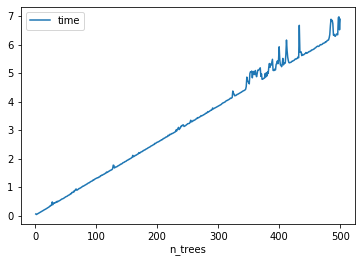

In [14]:
df_results.plot(x="n_trees", y="time");

Time increases almost linearly with `n_trees`, so by choosing 400 trees, we would get a very good and stable estimator, still quite expensive to train, but less expensive than 500 trees!

I am not sure about the big fluctuations of the otherwise very linear trend. It was a very rough estimate of time, each time was measured only once, so it is possible that fluctuations were caused by "external factors" on my computer, for instance me doing other stuff!